In [12]:
!pip -q install numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1 matplotlib==3.9.2 seaborn==0.13.2 joblib==1.4.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 19.2 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np

CSV_PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(CSV_PATH)

# Basic clean
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Target
df["Churn"] = df["Churn"].map({"Yes":1,"No":0}).astype(int)
print(df.shape); df.head(3)


(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer

TARGET = "Churn"
X = df.drop(columns=[TARGET])
y = df[TARGET]

SEED = 42

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Column groups
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

# Pull tenure out to discretize separately
num_cols_wo_tenure = [c for c in num_cols if c != "tenure"]

# Pipelines
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

tenure_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("kbins", KBinsDiscretizer(n_bins=6, encode="onehot-dense", strategy="quantile")),
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer
preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols_wo_tenure),  # all numeric EXCEPT tenure
    ("tenure_bin", tenure_tf, ["tenure"]),    # tenure becomes binned one-hot
    ("cat", categorical_tf, cat_cols),
])

In [15]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rf = RandomForestClassifier(
    n_estimators=500, n_jobs=-1, random_state=SEED,
    class_weight="balanced_subsample"
)
hgb = HistGradientBoostingClassifier(
    max_iter=400, learning_rate=0.05, random_state=SEED
)

rf_pipe  = Pipeline([("preprocess", preprocess), ("model", CalibratedClassifierCV(rf,  method="sigmoid", cv=3))])
hgb_pipe = Pipeline([("preprocess", preprocess), ("model", CalibratedClassifierCV(hgb, method="sigmoid", cv=3))])

rf_auc  = cross_val_score(rf_pipe,  X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
hgb_auc = cross_val_score(hgb_pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
print("RF  CV AUC:", rf_auc.mean().round(3), "±", rf_auc.std().round(3))
print("HGB CV AUC:", hgb_auc.mean().round(3), "±", hgb_auc.std().round(3))

best_name, pipe = (("HGB", hgb_pipe) if hgb_auc.mean() >= rf_auc.mean() else ("RF", rf_pipe))
print("→ Best model:", best_name)
pipe.fit(X_train, y_train)


RF  CV AUC: 0.83 ± 0.01
HGB CV AUC: 0.833 ± 0.01
→ Best model: HGB


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'SeniorCitizen',
                                                   'TotalCharges']),
                                                 ('tenure_bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbins',
                                                                   KBinsDiscretizer(encode='onehot-dense',
                                                                                    n_bins=6))]),
                                                  ['t...
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model',
                 CalibratedClassifierCV(cv=3,
                                        estimator=HistGradientBoostingClassifier(learning_rate=0.05,
                                                                                 max_iter=400,
                                                                                 random_state=42)))])

{'accuracy@0.50': 0.803, 'f1@0.50': 0.554, 'roc_auc': np.float64(0.834), 'pr_auc': np.float64(0.642)}
Suggested threshold (max F1): 0.30 | F1≈0.633


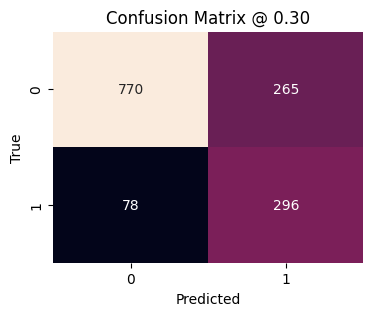


Classification report @ suggested threshold
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.53      0.79      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409



In [17]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, precision_recall_curve
)
import seaborn as sns, matplotlib.pyplot as plt
import numpy as np, pandas as pd

# Predict probabilities on test
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred_050 = (y_prob >= 0.50).astype(int)

# Default-threshold metrics
print({
    "accuracy@0.50": round(accuracy_score(y_test, y_pred_050), 3),
    "f1@0.50": round(f1_score(y_test, y_pred_050), 3),
    "roc_auc": round(roc_auc_score(y_test, y_prob), 3),
    "pr_auc": round(average_precision_score(y_test, y_prob), 3)
})

# F1-optimal threshold
prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1s = 2*(prec*rec)/np.clip(prec+rec, 1e-9, None)
if len(thr) > 0:
    best_idx = int(np.nanargmax(f1s[:-1]))
    best_thr = float(thr[best_idx])
    best_f1  = float(f1s[best_idx])
    print(f"Suggested threshold (max F1): {best_thr:.2f} | F1≈{best_f1:.3f}")
else:
    best_thr = 0.5

# Confusion matrix @ suggested threshold
y_pred_best = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix @ {best_thr:.2f}")
plt.show()

# Classification report
print("\nClassification report @ suggested threshold")
print(classification_report(y_test, y_pred_best))


In [18]:
import joblib
joblib.dump(pipe, "churn_pipeline.joblib")
"churn_pipeline.joblib"


'churn_pipeline.joblib'

In [19]:
%%writefile app_churn.py
import pandas as pd
import numpy as np
import streamlit as st
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)

st.set_page_config(page_title="Churn Predictor — Evaluate & Predict", layout="wide")
st.title("Customer Churn — Predictor & Evaluator")

# =========================
# Config
# =========================
DEFAULT_TARGETS = ["Churn", "churn", "Exited", "Target"]
LABEL_MAP = {"YES":1, "NO":0, "TRUE":1, "FALSE":0, "1":1, "0":0}

# =========================
# Load trained pipeline
# (expects a Pipeline with a ColumnTransformer named 'preprocess' or 'preprocessor')
# =========================
@st.cache_resource
def load_model(path="churn_pipeline.joblib"):
    return joblib.load(path)

pipe = load_model()

# =========================
# Helpers
# =========================
def normalize_labels(s: pd.Series) -> pd.Series:
    """Map common churn labels to 0/1; fallback to factorize for anything else."""
    s = pd.Series(s)
    if s.dtype == object:
        m = s.astype(str).str.strip().str.upper().map(LABEL_MAP)
        if m.isna().any():
            codes, _ = pd.factorize(s, sort=True)
            return pd.Series(codes, index=s.index).astype(int)
        return m.astype(int)
    return s.astype(int)

def get_expected_features(pipe):
    """
    Return (numeric_cols, categorical_cols) expected by the preprocessor.
    Treat any extra numeric-like transformers (e.g., 'tenure_bin') as numeric inputs too.
    """
    pre = pipe.named_steps.get("preprocess") or pipe.named_steps.get("preprocessor")
    num_cols, cat_cols = [], []
    if pre and hasattr(pre, "transformers_"):
        for name, trans, cols in pre.transformers_:
            if name in ("num", "tenure_bin"):
                num_cols += list(cols)
            elif name == "cat":
                cat_cols += list(cols)
            else:
                # default: if it's not the cat block, consider inputs numeric
                num_cols += list(cols)
    # deduplicate while keeping order
    num_cols = list(dict.fromkeys(num_cols))
    cat_cols = list(dict.fromkeys(cat_cols))
    return num_cols, cat_cols


def get_transformed_feature_names(pipe):
    """Return feature names after preprocessing (num + one-hot cat) aligned to the model."""
    pre = pipe.named_steps.get("preprocess") or pipe.named_steps.get("preprocessor")
    if pre is None:
        return None
    num_cols, cat_cols = get_expected_features(pipe)
    # OneHotEncoder lives at pre.named_transformers_["cat"].named_steps["onehot"]
    try:
        ohe = pre.named_transformers_["cat"].named_steps["onehot"]
        cat_names = ohe.get_feature_names_out(cat_cols).tolist() if cat_cols else []
    except Exception:
        cat_names = []
    return list(num_cols) + cat_names

def validate_schema(dfX, exp_num, exp_cat):
    expected = set(exp_num) | set(exp_cat)
    present  = set(dfX.columns)
    missing = sorted([c for c in expected if c not in present])
    extra   = sorted([c for c in present if c not in expected])
    return missing, extra

def unwrap_estimator(model):
    """If wrapped (e.g., CalibratedClassifierCV), return underlying estimator."""
    for attr in ("estimator", "base_estimator"):
        if hasattr(model, attr) and getattr(model, attr) is not None:
            return getattr(model, attr)
    return model

# --- Coerce numeric columns: blanks/whitespace -> NaN; strings -> numeric if possible ---
def coerce_numeric_columns(df: pd.DataFrame, numeric_cols: list[str]) -> pd.DataFrame:
    out = df.copy()
    for col in numeric_cols:
        if col not in out.columns:
            continue
        s = out[col].astype(str).str.strip()           # strip whitespace
        s = s.replace({"": np.nan})                    # empty -> NaN
        # Optional: remove thousand separators
        s = s.str.replace(",", "", regex=False)
        out[col] = pd.to_numeric(s, errors="coerce")   # to number (unparsable -> NaN)
    return out

# =========================
# Feature Info (dynamic)
# =========================
with st.expander("ℹ️ Feature Info"):
    exp_num, exp_cat = get_expected_features(pipe)
    if exp_num:
        st.markdown(f"- **Numeric** ({len(exp_num)}): {', '.join(exp_num)}")
    if exp_cat:
        st.markdown(f"- **Categorical** ({len(exp_cat)}): {', '.join(exp_cat)}")
    st.markdown("""
    **Target column (optional):**
    - Use `Churn` with values `Yes/No` or `1/0` for evaluation.
    - For predictions on new data, upload only feature columns (no target).
    """)

# =========================
# File upload
# =========================
uploaded = st.file_uploader("Upload CSV for evaluation/prediction", type=["csv"])
if not uploaded:
    st.info("Upload a CSV to continue.")
    st.stop()

df = pd.read_csv(uploaded)
st.subheader("Preview")
st.dataframe(df.head())

# =========================
# Tabs
# =========================
tab_eval, tab_pred = st.tabs(["📊 Evaluate (if target present)", "🔮 Predict"])

# =========================
# Evaluate tab
# =========================
with tab_eval:
    default_idx = 0
    if "Churn" in df.columns:
        default_idx = 1 + list(df.columns).index("Churn")
    tgt = st.selectbox("Target column", ["(none)"] + list(df.columns), index=default_idx)
    thr = st.slider("Decision threshold (prob ≥ threshold ⇒ churn)", 0.05, 0.95, 0.50, 0.01)

    if tgt != "(none)":
        # Split features/labels
        X = df.drop(columns=[tgt])
        y = normalize_labels(df[tgt])

        # Expected schema from pipeline
        exp_num, exp_cat = get_expected_features(pipe)

        # 🔧 Coerce numerics to handle blanks/strings in numeric columns
        X = coerce_numeric_columns(X, exp_num)

        # Validate schema
        missing, extra = validate_schema(X, exp_num, exp_cat)
        if missing:
            st.error("Missing required features:\n- " + "\n- ".join(missing))
            st.stop()
        if extra:
            st.info("These columns will be ignored by the model:\n- " + "\n- ".join(extra))

        # Predict
        y_prob = pipe.predict_proba(X)[:, 1]
        y_pred = (y_prob >= thr).astype(int)

        # Metrics
        acc = accuracy_score(y, y_pred)
        f1  = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_prob)
        prc = average_precision_score(y, y_prob)

        c1, c2, c3, c4 = st.columns(4)
        c1.metric("Accuracy", f"{acc:.3f}")
        c2.metric("F1", f"{f1:.3f}")
        c3.metric("ROC AUC", f"{auc:.3f}")
        c4.metric("PR AUC", f"{prc:.3f}")

        # Confusion Matrix
        st.write("#### Confusion Matrix")
        cm = confusion_matrix(y, y_pred)
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
        ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
        st.pyplot(fig)

        # Curves
        st.write("#### ROC / PR Curves")
        fig, ax = plt.subplots(); RocCurveDisplay.from_predictions(y, y_prob, ax=ax); st.pyplot(fig)
        fig, ax = plt.subplots(); PrecisionRecallDisplay.from_predictions(y, y_prob, ax=ax); st.pyplot(fig)

        # Suggested F1-optimal threshold
        P, R, T = precision_recall_curve(y, y_prob)
        F1 = 2 * (P * R) / np.clip(P + R, 1e-9, None)
        if len(T) > 0:
            best = int(np.nanargmax(F1[:-1]))  # align with thresholds array
            st.info(f"Suggested threshold (max F1): **{T[best]:.2f}** (F1≈**{F1[best]:.3f}**). "
                    "Move the slider to apply.")

        # Top features
        st.write("#### Top Features")
        try:
            names = get_transformed_feature_names(pipe) or []
            model = unwrap_estimator(pipe.named_steps.get("model", pipe))
            imp_df = None

            if hasattr(model, "feature_importances_"):  # trees
                vals = model.feature_importances_
                if not names or len(names) != len(vals):
                    names = [f"f{i}" for i in range(len(vals))]
                imp_df = pd.DataFrame({"feature": names, "importance": vals}) \
                           .sort_values("importance", ascending=False).head(20)

            elif hasattr(model, "coef_"):  # linear
                coefs = model.coef_[0] if np.ndim(model.coef_) > 1 else model.coef_
                if not names or len(names) != len(coefs):
                    names = [f"f{i}" for i in range(len(coefs))]
                imp_df = pd.DataFrame({"feature": names, "weight": coefs}) \
                           .assign(_abs=lambda d: d["weight"].abs()) \
                           .sort_values("_abs", ascending=False).drop(columns=["_abs"]).head(20)

            if imp_df is not None:
                st.dataframe(imp_df)
                fig, ax = plt.subplots(figsize=(6, max(3, 0.3 * len(imp_df))))
                col = "importance" if "importance" in imp_df.columns else "weight"
                imp_df.sort_values(col).plot(kind="barh", x="feature", y=col, ax=ax)
                ax.set_xlabel(col.capitalize()); ax.set_ylabel("Feature"); ax.set_title("Top Features")
                st.pyplot(fig)
            else:
                st.info("Model does not expose importances/coefficients.")
        except Exception as e:
            st.warning(f"Could not compute feature importance: {e}")
    else:
        st.info("Pick a target column to evaluate. Otherwise, switch to Predict.")

# =========================
# Predict tab
# =========================
with tab_pred:
    # Drop any target-like columns for inference
    drop_cols = [c for c in DEFAULT_TARGETS if c in df.columns]
    X_new = df.drop(columns=drop_cols) if drop_cols else df

    # Expected schema
    exp_num, exp_cat = get_expected_features(pipe)

    # 🔧 Coerce numerics for inference too
    X_new = coerce_numeric_columns(X_new, exp_num)

    # Validate schema
    missing, extra = validate_schema(X_new, exp_num, exp_cat)
    if missing:
        st.error("Missing required features:\n- " + "\n- ".join(missing))
        st.stop()
    if extra:
        st.info("These columns will be ignored by the model:\n- " + "\n- ".join(extra))

    # Predict
    prob = pipe.predict_proba(X_new)[:, 1]
    pred = (prob >= 0.50).astype(int)

    out = X_new.copy()
    out["prediction"] = pred
    out["prob_churn"] = prob

    st.success("Done. Showing first 10 rows.")
    st.dataframe(out.head(10))
    st.download_button("Download predictions.csv", data=out.to_csv(index=False), file_name="predictions.csv")


Overwriting app_churn.py


In [20]:
!pip -q install streamlit pyngrok==7.1.6
!pkill -f streamlit || true
!streamlit run app_churn.py --server.port 8501 &>/content/logs.txt &

from pyngrok import ngrok
import os
os.environ["NGROK_TOKEN"] = "2tZ6mqHFZ9n2B4HsTOzAPVA3Jnw_6qB1RFncPLxV8kcYUxNcJ"

if not os.environ.get("NGROK_TOKEN"):
    print("⚠️ Set NGROK_TOKEN above, then re-run this cell.")
else:
    ngrok.set_auth_token(os.environ["NGROK_TOKEN"])
    public_url = ngrok.connect(8501)
    print("✅ Public URL:", public_url)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.0 MB/s eta 0:00:00
^C
✅ Public URL: NgrokTunnel: "https://90a5678a6837.ngrok-free.app" -> "http://localhost:8501"
